## Load libraries

In [1]:
library(RWeka)
library(FSelector)

## Load data

In [2]:
class.attr <- "P17"

data.d1 <- read.arff("dataset/dataset_etapas_class17_idx1.arff");
data.d2 <- read.arff("dataset/dataset_etapas_class17_idx2.arff");
data.d3 <- read.arff("dataset/dataset_etapas_class17_idx3.arff");

# remove NEtapa attribute
data.total <- read.arff("dataset/dataset_etapas_class17_idx.arff");
data.attributes <- names(data.total)
data.attributes <- data.attributes[data.attributes != "NEtapa"]
data.total <- data.total[data.attributes]

# convenient list
datasets <- list(data.d1, data.d2, data.d3, "total"=data.total)

## Calculating rankings

In [3]:
# list without the classification attribute / P17
data.attributes.rank <- data.attributes[data.attributes != class.attr]

# let's initialize the dataframe with the attributes to be ranked
results <- data.frame(question=data.attributes.rank)

# ranking formula
form.rank <- as.formula(paste(class.attr, "~.", sep=''))

for (i in seq(1,3)){
    # get attributes minus P17
    df <- datasets[[i]][data.attributes]
    # calculate weights
    weights <- symmetrical.uncertainty(form.rank, df)
    # add a new column for the sub-dataset
    d.name <- paste("d", i, sep='')
    results[[d.name]] <- weights$attr_importance
}
# calculate rank for dataset "total"
df <- datasets[["total"]][data.attributes]
weights <- symmetrical.uncertainty(form.rank, df)
results[["total"]] <- weights$attr_importance

# sort based on "total" column
results <-results[order(results$total, decreasing = TRUE),]

print(results)

   question           d1           d2           d3       total
16      P16 1.970815e-01 0.1216236706 0.1948705180 0.178880159
2       P02 8.576754e-02 0.1945140291 0.1574870928 0.136294605
1       P01 1.595718e-01 0.1066124435 0.1267708001 0.133642615
11      P11 2.105397e-01 0.0000000000 0.0000000000 0.107572119
7       P07 1.482383e-01 0.1033461859 0.1516790045 0.106397261
12      P12 0.000000e+00 0.0000000000 0.0000000000 0.098787182
9       P09 0.000000e+00 0.1884341765 0.0000000000 0.096605778
13      P13 0.000000e+00 0.0000000000 0.0000000000 0.086124227
17      P18 9.186946e-02 0.1276441580 0.0089874904 0.061581731
8       P08 1.662741e-01 0.0601835270 0.0039449206 0.054744966
4       P04 4.243235e-02 0.1029642234 0.0463433230 0.050183610
5       P05 3.678905e-02 0.0986573025 0.0087864201 0.041516837
6       P06 9.110573e-03 0.1220306255 0.0069867783 0.032043067
3       P03 6.915974e-02 0.0005793417 0.0007318079 0.012895805
18      P19 8.984024e-05 0.0388085074 0.0002060199 0.00

## Plotting

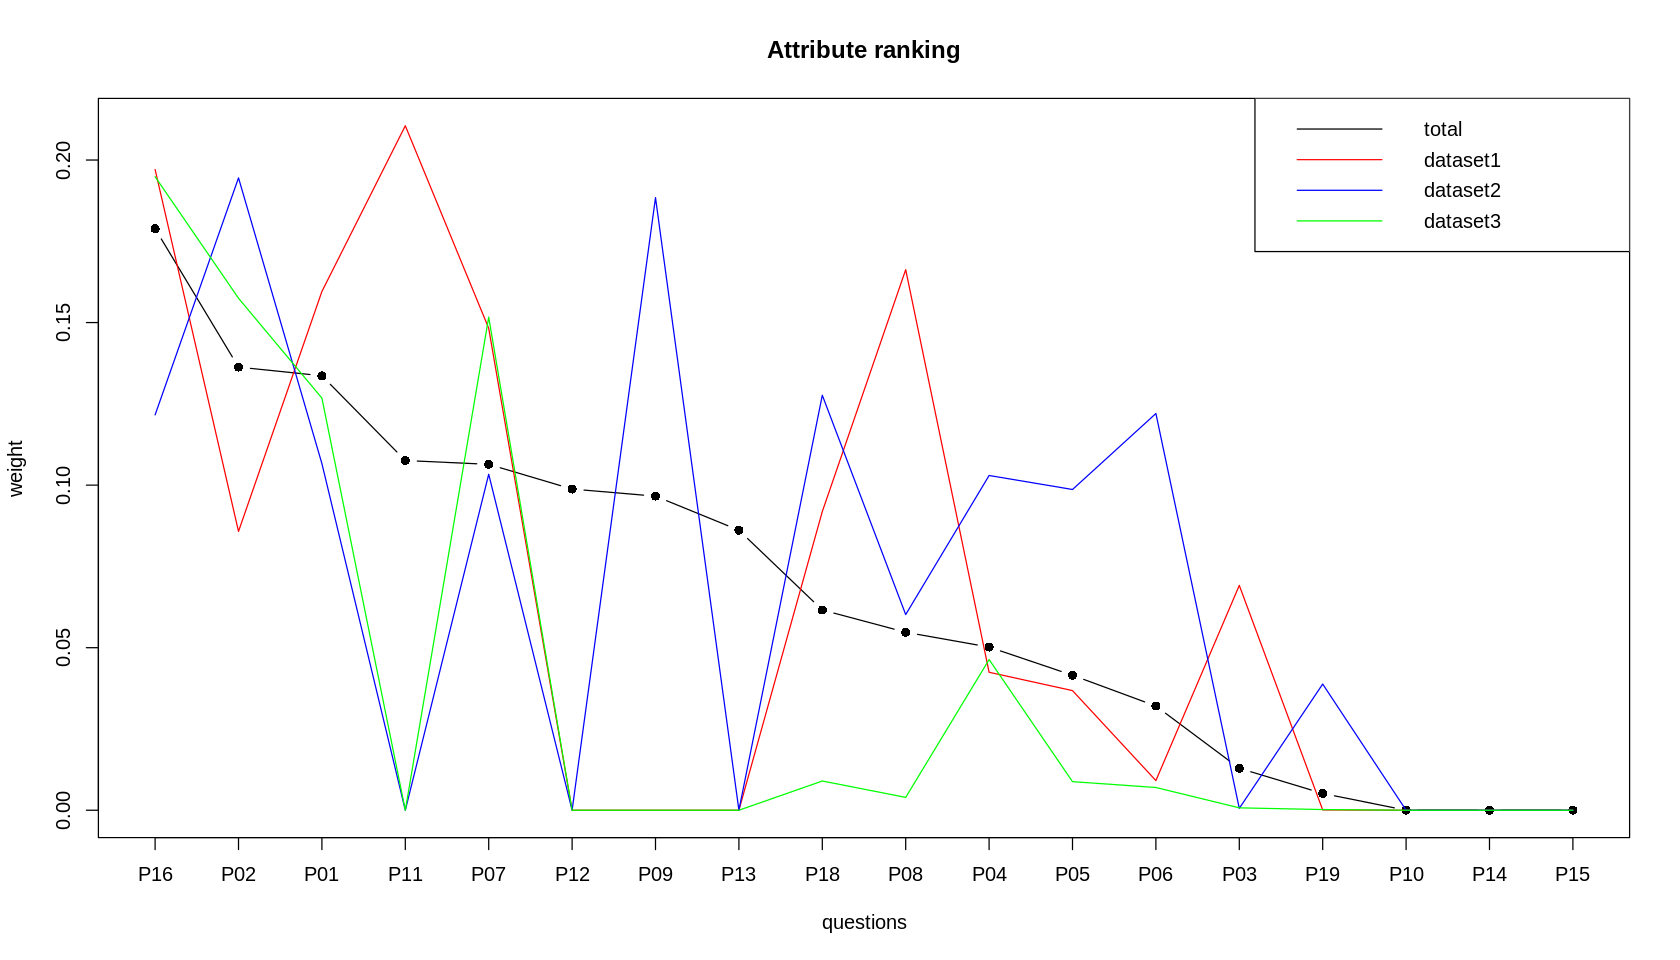

In [4]:
ymax <- max(apply(results[ , -1], 1, max, na.rm=TRUE))
ylim <- c(0, ymax)

options(repr.plot.width=14, repr.plot.height=8)

plot(results$total,
    main = "Attribute ranking",
    xlab = "questions",
    ylab = "weight",
    type = "b",
    pch = 16,
    xaxt = "n",
    ylim = ylim)

axis(1, at=seq(length(results$question)), labels=results$question)

lines(results$d1, type="l", pch=0, col="red")
lines(results$d2, type="l", pch=3, col="blue")
lines(results$d3, type="l", pch=5, col="green")

legend("topright",
       legend=c("total", "dataset1", "dataset2", "dataset3"),
       col=c("black", "red", "blue", "green"), 
       lty=1, 
       cex=1)

# Train

In [5]:
# createFold
library(caret)
# naive bayes
library(e1071)
# KNN
library(class)
#C4.5
library(C50)

Loading required package: lattice

Loading required package: ggplot2



In [13]:
# glimpse(dataset) 
# table(dataset$NEtapa)

# convert.aux <- function(df){
#     for(c in colnames(df)){
#         df[c] <- lapply(df[c], as.numeric)
#     }
#    return(df)
# }

multi.training <- function(kfolds, data, class.attr){
    
    folds <- createFolds(data[,1], k=kfolds, list=TRUE);
    # class.attr <- "P17"
    data.attributes <- colnames(data)
    data.attributes.learn <- data.attributes[data.attributes != class.attr]

    # formulas
    form.generic <- formula(paste(class.attr, "~ ."))
    form.bayes <- form.generic
    form.ibk <- form.generic
    #form.bayes <- formula(paste(class.attr, " ~ ", paste(data.attributes.learn, collapse = ' + ')))
    #form.ibk <- formula("P17~.")

for (i in 1:kfolds){

    # i-th set for testing
    test <- data[unlist(folds[i]), ]
    # remaining sets for training
    train <- data[unlist(folds[-i]), ]
    
    
    ###############
    # Naive Bayes #
    ###############
    model.bayes <- naiveBayes(form.bayes, train)
    
    pred.bayes <- predict(model.bayes, newdata=test) 
    # confusion Matrix 
    cm.bayes <- table(test[[class.attr]], pred.bayes) 
    # model evauation 
    confusionMatrix(cm.bayes)
    
    
    #######
    # NNK #
    #######
    # https://www.analyticsvidhya.com/blog/2015/08/learning-concept-knn-algorithms-programming/
    # k ~ sqrt(number observations)
    k <- sqrt(length(test) + length(train))
    
    # I tried this ...
    # train.knn <- convert.aux(train)
    # train.labels <- train$P17
    # test.knn <- convert.aux(train)
    # model.knn <- knn(train=train.knn, test=test.knn, cl=train.labels, k=k)
    
    # from RWeka
    # https://cran.r-project.org/web/packages/RWeka/index.html
    # IBk(formula, data, subset, na.action,control = Weka_control(), options = NULL)
    model.ibk <- IBk(form.ibk, data=train)
    pred.ibk <- predict(model.ibk, newdata=test)
    cm.ibk <- table(test[[class.attr]], pred.ibk)
    confusionMatrix(cm.ibk)
    
    
    ########################
    # C5.0 ~ J48 from Weka #
    ########################
    train.c50 <- train[data.attributes.learn]
    
    # empty spaces and accents ARE a problem
    # train.class <- sapply(train$P17, gsub, pattern=" ", replacement="_")
    train.class <- sapply(train[[class.attr]], gsub, pattern="Sí", replacement="si")
    train.class <- sapply(train.class, gsub, pattern="Más o menos", replacement="mas_o_menos")
    # we need factor outcome for the model
    train.class <- as.factor(train.class)
    
    test.class <- sapply(test[[class.attr]], gsub, pattern="Sí", replacement="si")
    test.class <- sapply(test.class, gsub, pattern="Más o menos", replacement="mas_o_menos")
    # we need factor outcome for the model
    test.class <- as.factor(test.class)
    
    model.c50 <- C5.0(train.c50, train.class, rules=TRUE)
    pred.c50 <- predict(model.c50, newdata=test)
    cm.c50 <- table(test.class, pred.c50)
    confusionMatrix(cm.c50)    
    
    ## let's accumulate matrices
    # conf.mat <- table(test[,"Aprobados"], fold.predict);
    # errs[i] <- 1-sum(diag(conf.mat))/sum(conf.mat);
    # accs[i] <- sum(diag(conf.mat))/sum(conf.mat);
    
}

}
# and we calculate stuff after the loop
# print(sprintf("average error using k-fold cross-validation: %.3f (%.3f) percent", 100*mean(errs), 100*sd(errs)));
# print(sprintf("average accuracy using k-fold cross-validation: %.3f (%.3f) percent", 100*mean(accs), 100*sd(accs)));

In [14]:
kfolds <- 10

multi.training(kfolds, data.total, "P17")



Confusion Matrix and Statistics

             pred.c50
test.class    mas_o_menos si
  mas_o_menos          10  0
  si                    1 10
                                          
               Accuracy : 0.9524          
                 95% CI : (0.7618, 0.9988)
    No Information Rate : 0.5238          
    P-Value [Acc > NIR] : 2.545e-05       
                                          
                  Kappa : 0.905           
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9091          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.9091          
             Prevalence : 0.5238          
         Detection Rate : 0.4762          
   Detection Prevalence : 0.4762          
      Balanced Accuracy : 0.9545          
                                          
       'Positive' Class : mas_o_menos    

In [8]:
# https://bioconductor.org/packages/devel/bioc/vignettes/FCBF/inst/doc/FCBF-Vignette.html#
# https://www.rdocumentation.org/packages/Biocomb/versions/0.4/topics/select.fast.filter


## Filter Features

instalar paquete: fastCorrBasedFS

Filtrado de atributos:
* attribute evaluator: SymmetricalUncertAttributeSetEval
* search method: FCBFSearch

```
=== Attribute Selection on all input data ===

Search Method:
	Attribute ranking.


     J || SU(j,Class) ||    I || SU(i,j). 
    16 ;    0.1788802 ;     *
     2 ;    0.1362946 ;     *
     1 ;    0.1336426 ;     2 ; 0.23226795599503008
    11 ;    0.1075721 ;     *
     7 ;    0.1063973 ;     2 ; 0.21037867835309815
    12 ;    0.0987872 ;    11 ; 0.3460006112293995
     9 ;    0.0966058 ;    11 ; 0.4175147034035191
    13 ;    0.0861242 ;    11 ; 0.3326517569987719
    15 ;    0.0730455 ;    11 ; 0.2835782921797696
    17 ;    0.0615817 ;     *
     8 ;    0.054745  ;     *
    14 ;    0.0505423 ;    11 ; 0.16635597639517383
     4 ;    0.0501836 ;    16 ; 0.07575072439001745
    10 ;    0.0499124 ;    11 ; 0.22435910766142814
     5 ;    0.0415168 ;    16 ; 0.08194073158116684
     6 ;    0.0320431 ;    16 ; 0.05367776683839208
     3 ;    0.0128958 ;    16 ; 0.024175761956890085
    18 ;    0.0051556 ;    16 ; 0.008505687958635275

Attribute Evaluator (supervised, Class (nominal): 19 P17):
	Symmetrical Uncertainty Ranking Filter

Ranked attributes:
 0.1789  16 P16
 0.1363   2 P02
 0.1076  11 P11
 0.0616  17 P18
 0.0547   8 P08

Selected attributes: 16,2,11,17,8 : 5
```

In [12]:
data.attributes.filter = c("P02", "P08", "P11", "P16", "P17", "P18")
data.total.filter <- data.total[data.attributes.filter]

kfolds <- 10

multi.training(kfolds, data.total.filter, "P17")

In [17]:
library(rbenchmark)
benchmark(
    "attributes_all" = {
        multi.training(kfolds, data.total, "P17")
    },
    "attributes_filter" = {
        multi.training(kfolds, data.total,filter, "P17")
    },
    replications = 1000,
    columns = c("test", "replications", "elapsed", "relative", "user.self", "sys.self")
)

ERROR: Error in library(rbenchmark): there is no package called ‘rbenchmark’
